# Pairs Trading: Como a Cointegração de Johansen em bancos brasileiros rendeu 15,39% de retorno acumulado em 15 dias.


Robert F. Engle e Clive W. J. Granger faturaram o Nobel de Economia em 2003 por uma série de trabalhos publicados sobre a Cointegração, uma técnica estatística que utiliza correções, estimativas e testes à não estacionariedade (não centralidade das propriedades estatísticas, como média e variância) de duas séries temporais no longo prazo.

Sendo a Cointegração uma técnica de paridade entre ativos, o chamado Pairs Trading, ou operação onde o investidor combina uma posição comprada long na baixa em 2 ativos cointegrados com vendas short na alta, e assim, vai obtendo lucros no spread a curto prazo e baixo risco devido à tendência de reversão à média dos ativos, as chaves dessa estratégia são a identificação esses ativos, a modelagem do spread temporal de preço e o estabelecimento do momentum da operação.

No nosso caso, utilizamos a Cointegração de Johansen por ser aplicável a múltiplas séries, como a análise de setores empresariais ou a análise situacional, como um portfolio. Após a aplicação do teste de Augmented Dikey Fuller para a não estacionariedade, a hipótese nula foi confirmada.
O teste de Jarque-Bera também confirmou a não normalidade da série. Logo, foi criado um algoritmo que simula a cointegração em intervalos de confiança que indicaram correlação de séries temporais em somente 2 dos 8 bancos analizados: Banco ABC (ABCB4) e Banco do Brasil (BBSE3).

Modelamos o spread da cotação entre os 2 bancos cointegrados, técnica desenvolvida pela primeira vez por Robert Elliot, em 2005. Estabelecemos a equação dessa relação entre o banco ABC (ativo-objeto) e o Banco do Brasil (ativo-alvo).

Ao utilizarmos estatísticas descritivas e cálculo do retorno do spread, observamos o melhor período para o trade: um espaço de 15 dias (entre os dias 7 e 22/11/2019).

Esse período trouxe, conforme o resumo do trade, um retorno de 15,39% e um índice Sharpe de 4,73.
Por fim, a volatilidade nesse período alcançou 4,87.

# 1) Importar bibliotecas

In [22]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
import seaborn
import matplotlib.pyplot as plt
import math

# 2) Web Scraping e Data Cleaning

In [23]:
# 8 bancos listados na Bovespa

# Critério de seleção: os 7 maiores bancos brasileiros em valor de mercado na data atual + 1 holding com participação relevante no setor
# Devido á importancia do fator Liquidez, outro critério importante seriam as negociações diárias dos papéis

ticker_bancos = ['ABCB4.SA', 'BPAC3.SA', 'ITUB4.SA', 'BBDC4.SA',  'ITSA4.SA', 'BRSR6.SA', 'SANB3.SA', 'BBAS3.SA', 'BPAN4.SA']

In [24]:
# Cotação das séries temporais

# Nota importante: O Value Investing objetiva o preço justo do ativo.
# Ao Pairs Trading não interessa o preço justo, e sim a flutuação do preço de ativos correlacionados em séries temporais.
# O Pairs Trading objetiva vender o ativo com preço mais alto e comprar o ativo mais barato uma vez que haja paridade
# e, quanto maior esse spread, maior o potencial de lucro.

# Logo, a chave do Pairs Trading é a identificação desses ativos, algo feito pelas técnicas de Cointegração.

# Outro corolário é que, se ambos os ativos possuem características semelhantes, seus preços serão mais ou menos o
# mesmo.
# Observe as cotações do banco ABC (ABCB4) e Banco do Brasil (BBAS3).
# BBSA3 foi a primeira empresa negociada na Bolsa, é estabilizada em suas estruturas de dívida e capital e sempre
# pagou bons dividendos (possui bom caixa), além de ter proteção governamental (entenda isso como algo positivo).
# ABCB4 teve seu IPO em 2007 e nos últimos 6 anos triplicou de preço.

# Logo, embora a leitura do balanço e outros testes estatísticos sejam necessários (deve-se jogar nas 11), é provável
# a qualificação do banco ABCB4 a também uma estratégia long only rumo à paridade.

cotacao = round(yf.download(ticker_bancos, start='2017-01-01')['Adj Close'].dropna(),2)
cotacao

[*********************100%%**********************]  9 of 9 completed


Ticker,ABCB4.SA,BBAS3.SA,BBDC4.SA,BPAC3.SA,BPAN4.SA,BRSR6.SA,ITSA4.SA,ITUB4.SA,SANB3.SA
Date,,,,,,,,,
2017-01-02,8.43,18.69,10.82,0.84,1.08,6.72,4.02,16.65,12.37
2017-01-03,8.79,19.55,11.28,0.84,1.04,7.08,4.20,17.36,13.03
2017-01-04,9.04,19.45,11.21,0.84,1.03,7.29,4.22,17.43,13.03
2017-01-05,9.19,19.40,11.33,0.90,1.03,7.40,4.26,17.67,13.12
2017-01-06,9.27,19.61,11.40,0.90,1.04,7.53,4.25,17.73,13.41
...,...,...,...,...,...,...,...,...,...
2024-01-18,23.57,55.34,15.67,17.91,8.01,13.89,9.99,32.86,13.89
2024-01-19,23.64,55.92,15.64,17.81,8.03,13.96,10.04,32.94,13.92
2024-01-22,23.06,55.55,15.46,18.39,7.87,13.53,9.91,32.40,13.95


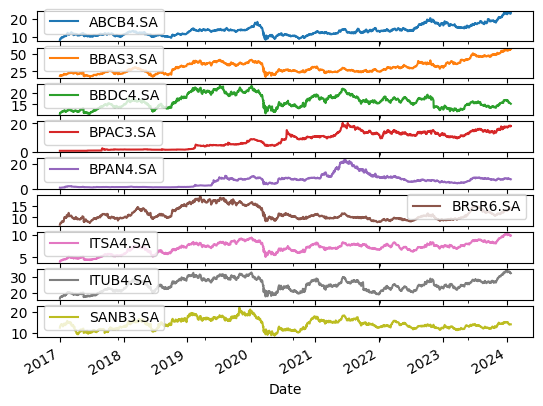

In [25]:
# Visualização das cotações no período

# Observe a dupla de papéis (ABCB4 e BBAS3) cujas cotações mais se parecem
# O algoritmo irá testar o que é observado

cotacao.plot(subplots=True);

# 3) Augmented Dickey Fuller test (ADF)

In [26]:
# ADF Test à não estacionariedade da série

# A hipótese nula no teste ADF afirma que a série é não-estacionária. A hipótese alternativa afirma a estacionariedade da série.
# O primeiro output é o ADF estatístico. Quanto mais negativo, maiores as evidências de aceitar a hipósese nula.
# Os principais outputs são o ADF estatístico e os valores críticos de 1%, 5% e 10%.
# Se o resultado do ADF test < valores cíticos, rejeita-se a hipótese nula (aceita a alternativa) e os dados são estacionários.
# Se o resultado do ADF test > valores cíticos, aceita a hipótese nula (rejeita a alternativa) e os dados são não-estacionários.

# Observe que na grande maiorias dos casos o ADF Test é > que os valores críticos.
# Isso afirma a não-estacionariedade da série para os ativos e a necessidade da Cointegração


ABCB4, BBAS3, BPAC3, ITUB4, BBDC4, ITSA4, BRSR6, SANB3, BPAN4 = adfuller(cotacao['ABCB4.SA']),  adfuller(cotacao['BBAS3.SA']), adfuller(cotacao['BPAC3.SA']),adfuller(cotacao['ITUB4.SA']), adfuller(cotacao['BBDC4.SA']), adfuller(cotacao['ITSA4.SA']), adfuller(cotacao['BRSR6.SA']), adfuller(cotacao['SANB3.SA']), adfuller(cotacao['BPAN4.SA'])
ABCB4, BBAS3, BPAC3, ITUB4, BBDC4, ITSA4, BRSR6, SANB3, BPAN4

((-0.7639497904824043,
  0.8294829182015344,
  1,
  1756,
  {'1%': -3.4340794333632534,
   '5%': -2.863187337213453,
   '10%': -2.567646992971705},
  527.0363543677554),
 (-0.5865107194484923,
  0.8740010123397804,
  7,
  1750,
  {'1%': -3.4340922388213175,
   '5%': -2.863192990001633,
   '10%': -2.5676500029387754},
  3620.0246352054655),
 (-1.0334481117174528,
  0.7408702747336919,
  24,
  1733,
  {'1%': -3.434129003198009,
   '5%': -2.863209218981072,
   '10%': -2.5676586444827656},
  1012.1750185634542),
 (-2.769841596879736,
  0.06271248523784491,
  11,
  1746,
  {'1%': -3.434100824760071,
   '5%': -2.863196780129223,
   '10%': -2.5676520210882936},
  2360.4105825938436),
 (-2.9134168894012396,
  0.04380989380548306,
  11,
  1746,
  {'1%': -3.434100824760071,
   '5%': -2.863196780129223,
   '10%': -2.5676520210882936},
  1248.9177687463794),
 (-2.294149891323817,
  0.1738616905315577,
  9,
  1748,
  {'1%': -3.4340965268715795,
   '5%': -2.863194882895319,
   '10%': -2.567651010857

# 4) Teste de Jarque-Bera

In [27]:
# Teste de Jarque-Bera       https://dataaspirant.com/jarque-bera-test/

# Testa o quão os dados fitam uma distribuição normal com assimetria e kurtose iguais a 0.
# É indicado para uma grande base de dados (> 2.000). Nossa amostra indica 1758 séries temporais, todavia decidi manter
# o teste para fins de conhecimento.
# Os resultados são: 1) O teste estatístico = É a diferença entre a assimetria e a curtose dos dados da distribuição
# normal. A distribuição normal que serve de comparação pode ser a de Shapiro ou a de Anderson-Darling
# (similar à Shapiro, porém mais sensível aos desvios na cauda da distribuição)
# Individualmente, quanto maior o valor do teste estatístico, maior a indicação  de não-normalidade
#                  e 2) O p-valor, cuja hipótese nula afirma que os dados fitam uma distribuição normal
# Um p-valor < 0.05 indica que devemos rejeitar a hipótese nula e indicar que os dados não fitam uma distribuição normal

# Temos uma grande evidência de que os dados não fitam uma distribuição normal, pois todos os p-valores são menores que 0.05

ABCB4_jb, BBAS3_jb, BPAC3_jb, ITUB4_jb, BBDC4_jb, ITSA4_jb, BRSR6_jb, SANB3_jb, BPAN4_jb = stats.jarque_bera(cotacao['ABCB4.SA']), stats.jarque_bera(cotacao['BBAS3.SA']), stats.jarque_bera(cotacao['BPAC3.SA']), stats.jarque_bera(cotacao['ITUB4.SA']), stats.jarque_bera(cotacao['BBDC4.SA']), stats.jarque_bera(cotacao['ITSA4.SA']), stats.jarque_bera(cotacao['BRSR6.SA']), stats.jarque_bera(cotacao['SANB3.SA']), stats.jarque_bera(cotacao['BPAN4.SA'])
ABCB4_jb, BBAS3_jb, BPAC3_jb, ITUB4_jb, BBDC4_jb, ITSA4_jb, BRSR6_jb, SANB3_jb, BPAN4_jb

(SignificanceResult(statistic=398.1595298969913, pvalue=3.4734145905873296e-87),
 SignificanceResult(statistic=204.00159534553552, pvalue=5.0305610163827365e-45),
 SignificanceResult(statistic=146.6195272791166, pvalue=1.4520252938404227e-32),
 SignificanceResult(statistic=56.36864371628727, pvalue=5.750485872352603e-13),
 SignificanceResult(statistic=76.69029317222693, pvalue=2.222871869535396e-17),
 SignificanceResult(statistic=34.46535060910358, pvalue=3.280531458826355e-08),
 SignificanceResult(statistic=292.20480418620986, pvalue=3.536168719804742e-64),
 SignificanceResult(statistic=48.48883511497301, pvalue=2.956536451413593e-11),
 SignificanceResult(statistic=517.5620931615865, pvalue=4.1003360244459945e-113))

# 5) Teste de Cointegração de Johansen

In [28]:
# Função que calcula o teste de Cointegração de Johansen

# A Cointegração de Johansen aponta a correlação de múltiplas séries temporais, e nesse caso, há somente 2 ativos
# cointegrados: Banco ABC e Banco do Brasil

def teste_cointegracao(cotacao, alpha=0.05):                                            # Um alpha padrão de 0.05 trás 95% de intervalo de confianção
  """ Teste de Cointegração"""
  saida = coint_johansen(cotacao, -1, 5)                                                # A saída é um Modelo de Vetor de Erro de Correção (VECM), um tipo especial de vetor autorregressivo aplicado em séries temporais
  dict = {'0.90':0,'0.95':1, '0.99':2}                                                  # Estipula um dicionário de valores críticos como um Dick Fuley Aumentado
  tracos_estatisticos = saida.lr1                                                       # Tracos estatistícos ou Lr1 é um nível de confiança de 99% para cada razão de vizinhança (likelihiid ratio) de teste
  valores_criticos = saida.cvt[:, dict[str(1-alpha)]]                                   # Calcula os valores críticos comparados ao intervalo de confiança de 95% (padrão)

  def formatar_print(val, length=6):                                                    # Função para ajustar (formatar) os valores de saída
    return str(val).ljust(length)

  print("Ticker\t||\t LR1 > Vlr Crítico \t=>Signif\t\n", '--'*25)                       # Alinhar os valores de saída à esquerda
  for col, traco, cvt in zip(cotacao.columns, tracos_estatisticos, valores_criticos):
    print(formatar_print(col), "|| ", formatar_print(round(traco,2), 7), ">",
          formatar_print(cvt,8), "=>", traco > cvt)                                     # Comparação booleana do traço estatístico LR1 (confiança de 99%) > valor crítico (padrão 95%)
                                                                                        # Os tickers cujo valor booleano é "True" estão cointegrados e se qualificam ao Pairs Trading

In [29]:
# Aplicação da função à série setorial dos bancos

teste_cointegracao(cotacao)

Ticker	||	 LR1 > Vlr Crítico 	=>Signif	
 --------------------------------------------------
ABCB4.SA ||  209.25  > 179.5199 => True
BBAS3.SA ||  154.23  > 143.6691 => True
BBDC4.SA ||  103.95  > 111.7797 => False
BPAC3.SA ||  68.78   > 83.9383  => False
BPAN4.SA ||  44.32   > 60.0627  => False
BRSR6.SA ||  26.75   > 40.1749  => False
ITSA4.SA ||  13.98   > 24.2761  => False
ITUB4.SA ||  3.01    > 12.3212  => False
SANB3.SA ||  0.26    > 4.1296   => False


# 6) Modelagem do Spread

In [30]:
# Modelagem do spread

# Spread é a avaliação incorreta mútua que o mercado faz no preço de 2 ativos cointegrados. Quanto maior essa avaliação
# incorreta, maior o spread e maior o potencial de lucro.
# Origem da utilização do Spread na cointegração: Pairs Tradind - Robert Elliot et al (2005) em: https://www.semanticscholar.org/paper/Pairs-trading-Elliott-Hoek/a7e887010e6aa7c7990f32d783750af8017ffabb

bidder = cotacao['ABCB4.SA']                      # Bidder é o ato de comprar ações ( ou ação que será comprada) a um determinado preço
target = cotacao['BBAS3.SA']                      # Target é a estimativa futura (paridade) do preço da ação estipulada como bidder
bidder = sm.add_constant(bidder)                  # Cria a coluna 'const' com valores iguais a 1. Trata-se de um requisito estrutural da OLS para que a estimativa dos mínimos quadrados seja realizada adequadamente
modelo = sm.OLS(target, bidder).fit()             # Treinar o modelo. OLS é a técnica indicada para estimar os parâmetros da relação linear entre as ações ABCB4 e BBAS3
bidder = bidder['ABCB4.SA']
beta = modelo.params['ABCB4.SA']                  # Coeficiente angular ou risco da ação ABCB4 à ação BBSE3
spread = target - beta * bidder                   # Fórmula do spread

In [31]:
spread.describe()

count    1758.000000
mean       -3.537791
std         4.187531
min       -14.964035
25%        -6.373949
50%        -4.271510
75%        -0.224514
max         7.388327
dtype: float64

In [32]:
# Spread da relação bidder, ou ativo objeto (ABCB4) e target, ou ativo alvo (BBSE3)

spread

Date
2017-01-02   -2.465933
2017-01-03   -2.509389
2017-01-04   -3.236789
2017-01-05   -3.663229
2017-01-06   -3.653997
                ...   
2024-01-18   -3.811285
2024-01-19   -3.406957
2024-01-22   -2.321389
2024-01-23   -1.682733
2024-01-24   -2.702053
Length: 1758, dtype: float64

In [33]:
spread.loc['2019-11-07':'2019-11-22']

Date
2019-11-07    0.904824
2019-11-08    0.445016
2019-11-11    0.509536
2019-11-12    0.611456
2019-11-13    0.156936
2019-11-14    0.250688
2019-11-18    0.521648
2019-11-19   -0.374600
2019-11-21   -0.050080
2019-11-22    0.720688
dtype: float64

In [34]:
# A modelagem do Spread - Regressão da Cointegração

# O beta (coeficiente angular) é o risco de mercado (sistemático) que indica a sensibilidade da ABCB4
# na queda ou alta das ações da BBSE3. O sinal positivo em 2.5 indica a direção proporcional (se BBSE3 sobe, ABCB4
# também sobe e vice-versa) e o valor indica que para cada aumento (ou queda) no preço de BBSE3 haverá aumento
# (ou queda) de 2.5 vezes em ABCB4.

# Coeficiente linear ou intercepto é o ponto em que a reta intercepta o eixo y(ABCB4) e indica variação marginal do
# spread.
# Ele indica a diminuição média no preço da ABCB4 para cada aumento no preço da BBSE3 (Na verdade, ao igualar ABCB4 a
# zero na equação do spread, chegamos a BBSE3 = 1.40. Isso indica que um spread entre zero e 1.40 em BBSE3 resulta num
# spread negativo em ABCB4. Fora desse intervalo o spread em ABCB4 é positivo.)

# A posição long-short da estratégia em 2 ativos é construída sob 2 premissas:
#     1) Quanto menor o beta, melhor.
#     2) E consequentemente, quanto menor a exposição ao mercado (sistemático, no caso exposição da ABCB4 à BBSE3), melhor

# Caso queira printar só a primeira parte: print(modelo.t_test([1, 0]))

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:               BBAS3.SA   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     5354.
Date:                Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:18:36   Log-Likelihood:                -5011.6
No. Observations:                1758   AIC:                         1.003e+04
Df Residuals:                    1756   BIC:                         1.004e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5378      0.479     -7.379      0.0

In [35]:
# Equação do Spread da relação linear ABCB4 e BBSE3

print('ABCB4 = ', round(modelo.params[1], 2),'*', 'BBSE3', round(modelo.params[0],2)  )

ABCB4 =  2.51 * BBSE3 -3.54


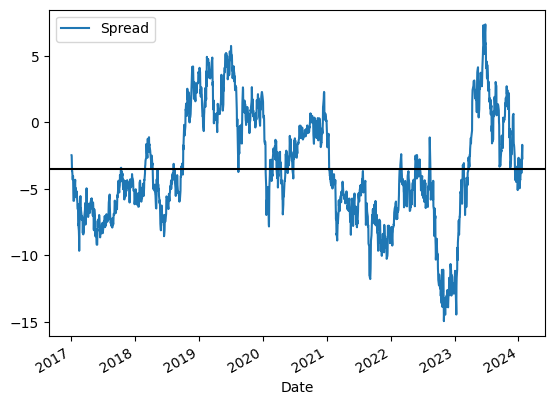

In [36]:
# Plotar o spread e analisar graficamente a tendência gaussiana

# Há drawdowns em 2019 e 2023

spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

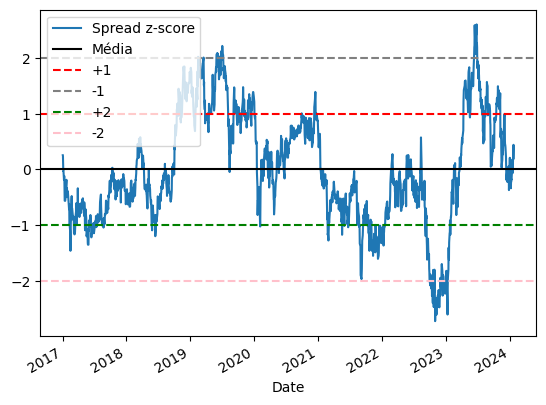

In [37]:
# Função zscore e plot das tendências negativa, gaussiana e positiva

# No trading, o ZScore é um indicador de risco probabilístico da tendência de movimento dos preços mensurado sob o desvio-padrão
# da média da série.
# Nesse caso estamos aplicando a função zscore ao spread e testando desvios-padrão discrepantes, para identificar
# tendências de paridade e comprar na baixa e/ou vender na alta.
# Observe o zscore do spread e as linhas de desvio padrão: O spread esteve em boa parte de 2017 abaixo de 1 desvio.
# Generalizando, não houve vantagem em fazer o spread dessa época até o fim de 2019, quando o spread disparou e foi
# acima de 2 desvios padrão. Esse foi o período que utilizamos como backtesting.
# Pelo gráfico, poderia-se pensar no spread abaixo de -2 dp que vai do início de 2023 ao spread acima 2 dp no meio
# desse ano. Todavia, o gráfico do retorno acumulado do spread mais abaixo nos mostrará que 2019 foi uma oportunidade,
# ao passo que 2023 não apresentou tal oportunidade.

def zscore(series):
    return (series - series.mean()) / np.std(series)                    # Calcula o zscore
zscore(spread).plot()                                                   # Plota o zscore e os desvios padrão
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(2.0, color='grey', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.axhline(-2.0, color='pink', linestyle='--')
plt.legend(['Spread z-score', 'Média', '+1', '-1', '+2', '-2']);

In [38]:
zscore(spread)

Date
2017-01-02    0.256037
2017-01-03    0.245657
2017-01-04    0.071901
2017-01-05   -0.029964
2017-01-06   -0.027758
                ...   
2024-01-18   -0.065330
2024-01-19    0.031253
2024-01-22    0.290565
2024-01-23    0.443122
2024-01-24    0.199634
Length: 1758, dtype: float64

In [39]:
# Criar um df da relação sinal ruído (SNR) e spread do par de ativos

trades = pd.concat([zscore(spread), spread], axis=1)
trades.columns = ["SNR", "spread"]

# Adicionar posições long e short nos níveis de zscore
trades["direcao"] = 0.0
trades.loc[trades.SNR <= -1, "direcao"] = 1
trades.loc[trades.SNR >= 1, "direcao"] = -1

# Os trades e as colunas de relação sinal ruído (SNR), o spread de preço dos ativos e a direção (tendência de alta ou baixa)
print(trades['direcao'].unique())
trades.head()

[ 0.  1. -1.]


,SNR,spread,direcao
Date,,,
2017-01-02,0.256037,-2.465933,0.0
2017-01-03,0.245657,-2.509389,0.0
2017-01-04,0.071901,-3.236789,0.0
2017-01-05,-0.029964,-3.663229,0.0
2017-01-06,-0.027758,-3.653997,0.0


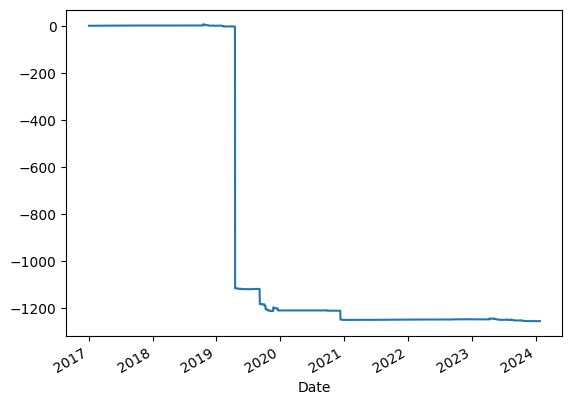

In [62]:
# Calcular o retorno acumulado do spread e plotar a curva

# Uma comparação interessante ao plot da função zscore é que esta exibe o spread da relação entre os ativos e apresenta
# aparentes oportunidades em 2019 e 2023.
# Contudo, na verdade, o gráfico do retorno acum aponta 3 momentos:
    # 1) O par vem perdendo dinheiro desde o início de 2019 porém,
    # 2) Houve uma oportunidade de trade diário no final de 2019, no dia 21/11/2019 e,
    # 3) Ao contrário do que se pensava, 2023 não foi um ano vantajoso ao trading dessa cointegração

retorno = trades.spread.pct_change() * trades.direcao
retorno_acum = retorno.cumsum()
retorno_acum.plot();

# 7) Selecionar o melhor período de trade com base no gráfico retorno acumulado


In [41]:
# Com base na visualização gráfica, o período escolhido filtra os períodos mais baixos e o topo para calcular as
# estatísticas da carteira

ret_periodo_escolhido = retorno_acum.loc['2019-10-1':'2021-6-1']
ret_periodo_escolhido

Date
2019-10-01   -1183.449868
2019-10-02   -1183.449868
2019-10-03   -1189.541499
2019-10-04   -1189.767255
2019-10-07   -1189.410433
                 ...     
2021-05-26   -1249.299510
2021-05-27   -1249.299510
2021-05-28   -1249.299510
2021-05-31   -1249.202020
2021-06-01   -1249.202020
Length: 411, dtype: float64

In [42]:
# Estatística Descritiva do periodo

ret_periodo_escolhido.describe()

count     411.000000
mean    -1219.892274
std        18.726531
min     -1249.540111
25%     -1249.299510
50%     -1209.297670
75%     -1209.275219
max     -1183.449868
dtype: float64

In [43]:
# Com base na estatística descritiva, o melhor período de retorno foi entre 7/11/2019 e 22/11/2019

print(ret_periodo_escolhido.nsmallest(1))
print(ret_periodo_escolhido.nlargest(1))


Date
2020-12-23   -1249.540111
dtype: float64
Date
2019-10-01   -1183.449868
dtype: float64


In [44]:
# Melhor período de retorno

# Filtrando mais, podemos identificar a data exata para o trade: entre os dias 21/11/2019 (comprar na baixa = o mínimo
# de retorno acumulado) e o dia 22/11/2019 (vender na alta = o máximo de retorno acumulado)

ret_melhor_periodo = ret_periodo_escolhido.loc['2019-11-07':'2019-11-22']
ret_melhor_periodo

Date
2019-11-07   -1211.841279
2019-11-08   -1211.841279
2019-11-11   -1211.841279
2019-11-12   -1211.841279
2019-11-13   -1211.841279
2019-11-14   -1211.841279
2019-11-18   -1211.841279
2019-11-19   -1211.841279
2019-11-21   -1211.841279
2019-11-22   -1196.450507
dtype: float64

In [45]:
# Finalmente, essa é a data do trade de maior retorno

ret_melhor_periodo_fim = ret_periodo_escolhido.loc['2019-11-21':'2019-11-22']
ret_melhor_periodo_fim

Date
2019-11-21   -1211.841279
2019-11-22   -1196.450507
dtype: float64

In [46]:
# Analisar o spread do melhor período
# Como em ret_melhor_periodo_fim, observe o spread entre os dias 21 e 22/11/2019. Ele parte negativo no dia 21, para
# altamente positivo no dia 22.


spread.loc['2019-11-07':'2019-11-22']

Date
2019-11-07    0.904824
2019-11-08    0.445016
2019-11-11    0.509536
2019-11-12    0.611456
2019-11-13    0.156936
2019-11-14    0.250688
2019-11-18    0.521648
2019-11-19   -0.374600
2019-11-21   -0.050080
2019-11-22    0.720688
dtype: float64

In [47]:
# Retorno do trade com estratégia de Pairs Trading entre os dias 7 e 22/11/2019 nas ações da ABCB4 (bidder) e BBSE3 (target)

# Esse é o retorno bruto, sem contas custos de transação e dividendos


retorno_estrategia = round(- ret_melhor_periodo.min() + ret_melhor_periodo.max(),2)
retorno_estrategia

15.39

In [48]:
# Máximo Drawdown do melhor período

# Mensura a perda máxima percentual entre maior retorno do pico e menor retorno do pico durante um período

max_drawdown = round((ret_melhor_periodo.min() - ret_melhor_periodo.max() ) / ret_melhor_periodo.max() * 100, 2)
max_drawdown

1.29

In [50]:
# Volatilidade (Desvio padrão) do melhor periodo

round(ret_melhor_periodo.std(), 2)

4.87

In [51]:
retorno.loc['2019-11-07':'2019-11-23']

Date
2019-11-07    -0.797826
2019-11-08    -0.000000
2019-11-11     0.000000
2019-11-12     0.000000
2019-11-13    -0.000000
2019-11-14     0.000000
2019-11-18     0.000000
2019-11-19    -0.000000
2019-11-21    -0.000000
2019-11-22    15.390773
dtype: float64

In [52]:
# ìndice Sharpe

# Observe que quanto maior o índice Sharpe, maior o desempenho do investimento ajustado ao risco.
# Um índice Sharpe entre 1 e 2 é considerado bom. Entre 2 e 3 é muito bom e acima de 3 é excelente.

# Taxa Selic ao ano: 6.4%. Diária = 6.4/252 https://www.bcb.gov.br/htms/SELIC/SELICdiarios.asp?frame=1
exc_retorno = retorno.loc['2019-11-07':'2019-11-23']- (6.4/252)

sharpe_ratio = round((math.sqrt(252) * retorno.loc['2019-11-07':'2019-11-23'].mean()) / retorno.loc['2019-11-07':'2019-11-23'].std(),2)
print(sharpe_ratio)


4.73


In [53]:
# Estatísticas descritivas do retorno acumulado

retorno_acum.describe()

count    1757.000000
mean     -827.406932
std       576.332997
min     -1254.802497
25%     -1248.029608
50%     -1209.275219
75%         0.450170
max         5.877098
dtype: float64

# 8) Estatísticas do Trade

In [58]:
# Estatísticas do Trade

df = pd.DataFrame()
index_labels= ['Retorno', 'Índice Sharpe', 'CDI diário', 'Volatilidade']
df = pd.DataFrame(df,index=index_labels)
title = 'Top 10 Fields of Research by Aggregated Funding Amount'
df['Valor'] = 'Valor'
df.xs('Retorno')['Valor'] = round(- ret_melhor_periodo.min() + ret_melhor_periodo.max(),2)
df.xs('Índice Sharpe')['Valor'] = round((math.sqrt(252) * retorno.loc['2019-11-07':'2019-11-23'].mean()) / retorno.loc['2019-11-07':'2019-11-23'].std(),2)
df.xs('CDI diário')['Valor'] = round(6.4/252,2)
df.xs('Volatilidade')['Valor'] = round(ret_melhor_periodo.std(), 2)
df

,Valor
Retorno,15.39
Índice Sharpe,4.73
CDI diário,0.03
Volatilidade,4.87


# 9) Conclusão

Ao passarmos pela modelagem do spread, inferir hipóteses através do testes ADF e Jaque-Bera e calcular o backtesting da estratégia, passamos por importantes estágios da Estatística aplicada às finanças.

A estratégia mostrou-se interessante, pois um dos corolários da Cointegração é o risco próximo de zero e a descorrelação com o risco de mercado (como vimos no beta negativo).

O físico Nunzio Tartaglia foi o primeiro a aplicar a cointegração na década de 80 em finanças e, como tudo na vida tende a melhorar, a literatura preditiva indica o algoritmo de redes neurais de backpropagation para a previsão de preços e retornos de ações.